# S or R? Unveiling E. Coli’s Cefepime Resistance Patterns
###  Anayna Singh
December 5, 2024



Antibiotic resistance is a critical global health challenge,
and effective predictive models can aid in understanding
and combating it.
 In this project I built a predictive model for Cefepime
Susceptibility (S) vs. Resistance (R) in Escherichia coli.

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from tensorflow import keras
from collections import defaultdict
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the dataset

seed = 130

def load_data():

    # Presence absence features
    train_pa_genes = pd.read_csv('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/test_pa_genes.csv').set_index('genome_id')

    # Load Kmer data
    train_kmers = np.load('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/test_kmers.npy', allow_pickle=True)

    # Load target data & IDs
    y_train = np.load('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/test_ids.npy', allow_pickle=True).astype(str)

    # Load raw gene data for optional neural network section
    train_gene_alignment = pd.read_csv('/content/drive/MyDrive/Antibiotic_Resistance_Susceptibility/train_test_data/train_genes.csv')

    return train_pa_genes, test_pa_genes, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment

train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

In [4]:
# Dataset Processing

X_train_pa = np.array(train_pa_genes)
X_test_pa = np.array(test_pa_genes)

In [5]:
# Sample Weighting

sample_weights = sklearn.utils.class_weight.compute_sample_weight("balanced", y_train)

# Check the weights for a few samples
pd.DataFrame(list(zip(y_train[0:10], sample_weights[0:10])), columns=['y_train', 'weight'])

,y_train,weight
0,[S],0.625418
1,[S],0.625418
2,[S],0.625418
3,[S],0.625418
4,[S],0.625418
5,[S],0.625418
6,[R],2.493333
7,[S],0.625418
8,[R],2.493333
9,[R],2.493333


Used sample weighting here to deal with the imbalanced classes and checked the weights to make sure they're sensible with R being upweighted and S downweighted.

In [6]:
# Combine PA features and k-mer features
X_train = np.hstack((X_train_pa, X_train_kmers))
X_train = X_train.astype(np.float32)
X_test = np.hstack((X_test_pa, X_test_kmers))
X_test = X_test.astype(np.float32)

Joined the features presence-absence data (genes) and k-mer representations together into a single feature matrix.

Feature Importance

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Total PA Feature Importance: 0.00
Total k-mer Feature Importance: 1.00


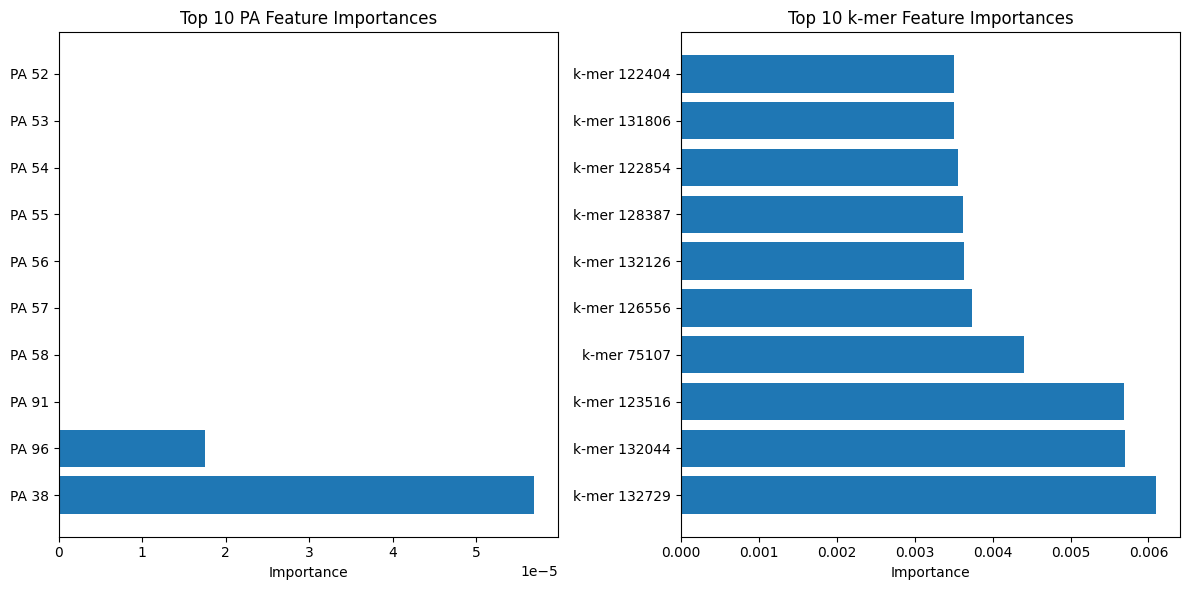

In [7]:

# Step 1: Train a Random Forest model
rf_model = RandomForestClassifier(random_state=seed, n_estimators=100, class_weight="balanced")
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

# Step 2: Calculate feature importances
feature_importances = rf_model.feature_importances_

# Step 3: Separate PA and k-mer feature importance
num_pa_features = X_train_pa.shape[1]
pa_importances = feature_importances[:num_pa_features]
kmer_importances = feature_importances[num_pa_features:]

# Aggregate importance by feature type
total_pa_importance = np.sum(pa_importances)
total_kmer_importance = np.sum(kmer_importances)

# Display results
print("Total PA Feature Importance: {:.2f}".format(total_pa_importance))
print("Total k-mer Feature Importance: {:.2f}".format(total_kmer_importance))

# Step 4: Visualize feature importances (Optional)
import matplotlib.pyplot as plt

# Sort PA and k-mer importances for visualization
sorted_pa_idx = np.argsort(pa_importances)[::-1]
sorted_kmer_idx = np.argsort(kmer_importances)[::-1]

plt.figure(figsize=(12, 6))

# Plot top 10 PA features
plt.subplot(1, 2, 1)
plt.barh(range(10), pa_importances[sorted_pa_idx[:10]])
plt.yticks(range(10), [f"PA {i}" for i in sorted_pa_idx[:10]])
plt.title("Top 10 PA Feature Importances")
plt.xlabel("Importance")

# Plot top 10 k-mer features
plt.subplot(1, 2, 2)
plt.barh(range(10), kmer_importances[sorted_kmer_idx[:10]])
plt.yticks(range(10), [f"k-mer {i}" for i in sorted_kmer_idx[:10]])
plt.title("Top 10 k-mer Feature Importances")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()

Baseline model

In [8]:
# Split the training data (X_train, y_train) into 80% for training and 20% for testing
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train_new, y_train_new)

# Make predictions
y_pred = knn_model.predict(X_test_new)

# Evaluate the model
accuracy = accuracy_score(y_test_new, y_pred)
print("KNN Model Accuracy: {:.2f}%".format(accuracy * 100))

# Display classification report
print(classification_report(y_test_new, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Model Accuracy: 86.00%
              precision    recall  f1-score   support

           R       0.76      0.56      0.64        34
           S       0.88      0.95      0.91       116

    accuracy                           0.86       150
   macro avg       0.82      0.75      0.78       150
weighted avg       0.85      0.86      0.85       150



LightGBM model

In [10]:
seed = 42  # Random seed

# Subsample the data (reduce dataset size for testing)
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(X_train_new, y_train_new, test_size=0.7, random_state=seed, stratify=y_train_new)

In [11]:
# Function for tuning
def tune_model_randomized(model, param_distributions, X, y, n_iter=10, cv=3):
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=n_iter, cv=cv,
        scoring='accuracy', random_state=seed, n_jobs=-1, verbose=1
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

In [15]:
import warnings
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import numpy as np

warnings.filterwarnings("ignore")

def fit_model(model, X_train, y_train):
    """
    Fits a model to the training data.

    Args:
        model: The model to fit.
        X_train: The training data.
        y_train: The target variable.

    Returns:
        The trained model.
    """
    print("Fitting the model...\n")

    try:
        model.fit(X_train, y_train)
        print("Model fitting completed.")
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return None

    return model

lgb_model = LGBMClassifier(random_state=42)

# Split the data into training and test sets
# Assuming X_sample and y_sample are already defined
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Fit the model to the training data
trained_lgb = fit_model(lgb_model, X_train, y_train)

# Evaluate the model on the test set
if trained_lgb is not None:
    y_pred = trained_lgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy on the test set: {accuracy:.4f}")
else:
    print("\nModel fitting failed.")


Fitting the model...

[LightGBM] [Info] Number of positive: 113, number of negative: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181832
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 79365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.790210 -> initscore=1.326190
[LightGBM] [Info] Start training from score 1.326190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit